# Mini-Project 2: Time Series Forecasting

### CSC 215-01 Artificial Intelligence (Fall 2019)

### Team member : 
    1) Ayushi Vadwala
    2) Jeet Shah

### Problem Formulation :   
    Time series forecasting is an important area of AI. It is important because there are so many prediction problems that involve a time component. This time component makes time series problems more difficult to handle. In this project, we have practiced with time series data to predict stock price. Predict [Close] of a day based on the last 7 days’ data [Open, High, Low, Volume, Close] using different model.
            
### Models used to predict Stock Price : 
- Fully-Connected Neural Networks
- Long short-term memory (LSTM)
- Convolutional Neural Network (CNN)

In [1]:
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=0, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    

def to_sequences(seq_size, data1 ,data2):
    x = []
    y = []

    for i in range(len(data1)-SEQUENCE_SIZE-1):
        #print(i)
        window = data1[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        #window = [[x] for x in window]
       #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

def to_sequences_cnn(seq_size, data1 ,data2):
    x = []
    y = []

    for i in range(len(data1)-SEQUENCE_SIZE-1):
        #print(i)
        window = data1[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
       #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)


#### Load dataset into pandas dataframe

In [3]:
import pandas as pd

df = pd.read_csv('data/CSC215_P2_Stock_Price.csv')

In [4]:
df[:5]

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


#### Droped columns of no use

In [5]:
df.drop(['Date','Adj_Close'], axis=1, inplace=True)

In [6]:
df[:5]

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [7]:
df = df.dropna() #drop any null value row

In [8]:
df.shape

(4392, 5)

In [9]:
df = df.drop_duplicates(keep='first', inplace=False) #removing dulicates

In [10]:
df.shape

(4392, 5)

#### Stored all the values of to be predicted column to a list called df_stock_close

In [11]:
df_stock_close = df['Close'].tolist()

In [12]:
df_stock_close[:10]

[4.125,
 4.015625,
 4.0,
 3.84375,
 3.390625,
 3.4375,
 3.5,
 3.484375,
 3.578125,
 3.609375]

#### Normalized input feature into range from 0 to 1 with the use of predefined defination

In [13]:
encode_numeric_range(df, 'Close')
encode_numeric_range(df, 'Open')
encode_numeric_range(df, 'High')
encode_numeric_range(df, 'Low')
encode_numeric_range(df, 'Volume')

In [14]:
df[:5]

,Open,High,Low,Close,Volume
0,0.004378,0.006469,0.006934,0.007408,0.075401
1,0.007031,0.006205,0.008535,0.006482,0.019194
2,0.005970,0.005413,0.008135,0.006350,0.005339
3,0.005970,0.005149,0.007201,0.005027,0.036632
4,0.003714,0.002904,0.003334,0.001191,0.167478


# Full-Connected Neural Network Model

In [15]:
#Preparing x and y
SEQUENCE_SIZE = 7
x,y = to_sequences(SEQUENCE_SIZE, df.values, df_stock_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4384, 7, 5)
Shape of y: (4384,)


#### Reshaped input data as a 35 feature using each 7 rows and 5 columns

In [16]:
x_NN = x.reshape(4384,7*5)
y_NN = y

In [17]:
x_NN.shape

(4384, 35)

In [18]:
y_NN.shape

(4384,)

In [19]:
import warnings
warnings.filterwarnings('ignore')

#### Split data into 70% train and 30% test using scikit learn's 'train_test_split'

In [20]:
x_train_NN,x_test_NN,y_train_NN,y_test_NN = train_test_split(x_NN,y_NN, test_size=0.3, random_state =42)
print("Shape of x_train: {}".format(x_train_NN.shape))
print("Shape of x_test: {}".format(x_test_NN.shape))
print("Shape of y_train: {}".format(y_train_NN.shape))
print("Shape of y_test: {}".format(y_test_NN.shape))

Shape of x_train: (3068, 35)
Shape of x_test: (1316, 35)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [21]:
# Load modules
import io
import requests
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras import regularizers

In [22]:
save_path = "./dnn/"

checkpointer = ModelCheckpoint(filepath="dnn/best_weights_NN.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)
    model = Sequential()
    
    model.add(Dense(150,input_dim=x_train_NN.shape[1], activation='relu'))   # hidden 1 
    model.add(Dropout(0.10))
    model.add(Dense(100,activation='relu')) # Hidden 2
    model.add(Dropout(0.10))
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.10))
    model.add(Dense(1)) # Output
    
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')

    model.fit(x_train_NN,y_train_NN,validation_data=(x_test_NN,y_test_NN),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)


W1009 16:46:39.350965  6556 deprecation.py:506] From C:\Users\Jeet\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


0
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 1s - loss: 596.6123 - val_loss: 2.9708
Epoch 2/1000
3068/3068 - 0s - loss: 22.5386 - val_loss: 1.9400
Epoch 3/1000
3068/3068 - 0s - loss: 21.2036 - val_loss: 2.1922
Epoch 4/1000
3068/3068 - 0s - loss: 21.1316 - val_loss: 1.9921
Epoch 5/1000
3068/3068 - 0s - loss: 20.5363 - val_loss: 3.4314
Epoch 6/1000
3068/3068 - 0s - loss: 20.8972 - val_loss: 1.8430
Epoch 7/1000
3068/3068 - 0s - loss: 18.9629 - val_loss: 3.6060
Epoch 8/1000
3068/3068 - 0s - loss: 19.8714 - val_loss: 1.9020
Epoch 9/1000
3068/3068 - 0s - loss: 16.6408 - val_loss: 3.4098
Epoch 10/1000
3068/3068 - 0s - loss: 17.7444 - val_loss: 8.3422
Epoch 11/1000
3068/3068 - 0s - loss: 19.0748 - val_loss: 1.9724
Epoch 00011: early stopping
1
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 1s - loss: 506.2125 - val_loss: 5.2352
Epoch 2/1000
3068/3068 - 0s - loss: 18.1533 - val_loss: 2.4664
Epoch 3/1000
3068/3068 - 0s - loss: 20.8588 - val

In [23]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights('dnn/best_weights_NN.hdf5')
neural_pred = model.predict(x_test_NN)

score = np.sqrt(metrics.mean_squared_error(y_test_NN,neural_pred)) 

print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(y_test_NN, neural_pred))
print("R2 score     :",metrics.r2_score(y_test_NN,neural_pred))

RMSE         : 1.3381664680931495
MSE          : 1.7906894963288942
R2 score     : 0.9978600925209185


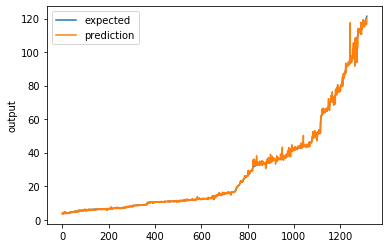

In [24]:
chart_regression(neural_pred.flatten(),y_test_NN)

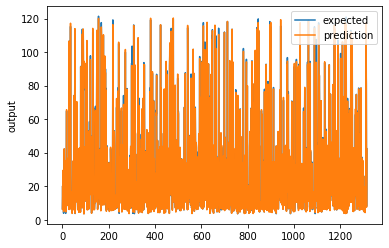

In [25]:
chart_regression(neural_pred.flatten(),y_test_NN,sort=False)

# LSTM

#### Each record is a sequence of 7 vectors and each vector with 5 dimensions and then split data into train and test

In [26]:
x_train_lstm,x_test_lstm,y_train_lstm,y_test_lstm = train_test_split(x,y, test_size=0.3, random_state =42)
print("Shape of x_train: {}".format(x_train_lstm.shape))
print("Shape of x_test: {}".format(x_test_lstm.shape))
print("Shape of y_train: {}".format(y_train_lstm.shape))
print("Shape of y_test: {}".format(y_test_lstm.shape))

Shape of x_train: (3068, 7, 5)
Shape of x_test: (1316, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [27]:
#checkpointer
checkpointer = ModelCheckpoint(filepath="best_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    print(i)    
    print('Build model...')
    model = Sequential()
    model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1,input_shape=(7, 5)))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 


0
Build model...


W1009 16:47:37.220145  6556 deprecation.py:323] From C:\Users\Jeet\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train...
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 5s - loss: 598.9823 - val_loss: 17.2369
Epoch 2/1000
3068/3068 - 2s - loss: 41.1422 - val_loss: 5.9252
Epoch 3/1000
3068/3068 - 2s - loss: 32.5728 - val_loss: 4.0566
Epoch 4/1000
3068/3068 - 2s - loss: 26.1121 - val_loss: 7.7658
Epoch 5/1000
3068/3068 - 2s - loss: 28.8099 - val_loss: 4.2974
Epoch 6/1000
3068/3068 - 2s - loss: 25.2148 - val_loss: 2.5564
Epoch 7/1000
3068/3068 - 2s - loss: 24.5679 - val_loss: 2.4221
Epoch 8/1000
3068/3068 - 3s - loss: 20.6305 - val_loss: 3.6709
Epoch 9/1000
3068/3068 - 2s - loss: 21.8960 - val_loss: 2.5928
Epoch 10/1000
3068/3068 - 2s - loss: 20.7886 - val_loss: 5.0581
Epoch 11/1000
3068/3068 - 3s - loss: 21.2693 - val_loss: 3.3818
Epoch 12/1000
3068/3068 - 3s - loss: 20.6194 - val_loss: 3.0939
Epoch 00012: early stopping
1
Build model...
Train...
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 4s - loss: 652.5852 - val_loss: 20.2440
Epoch 2/1000
30

RMSE         : 1.3889606834667212
MSE          : 1.929211780216341
R2 score     : 0.9976945557978194


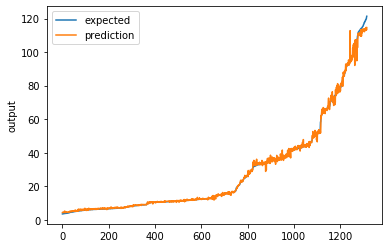

In [28]:
model.load_weights('best_weights_lstm.hdf5')
pred = model.predict(x_test_lstm)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_lstm))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(y_test_lstm, pred))
print("R2 score     :",metrics.r2_score(y_test_lstm,pred))
# Plot the chart
chart_regression(pred.flatten(),y_test_lstm)

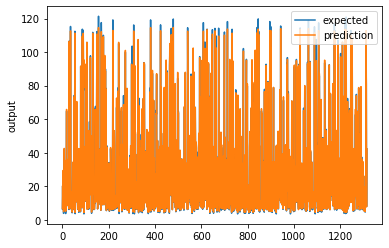

In [29]:
chart_regression(pred.flatten(),y_test_lstm,sort=False)

# CNN 

#### Each record viewed as an image that has 7 pixels and each pixel with 5 channels.

In [30]:
#Preparing x and y
SEQUENCE_SIZE = 7
x_cnn,y_cnn = to_sequences_cnn(SEQUENCE_SIZE, df.values, df_stock_close)
#x_test,y_test = to_sequences(SEQUENCE_SIZE, df_test, close_test)

print("Shape of x: {}".format(x_cnn.shape))
print("Shape of y: {}".format(y_cnn.shape))

Shape of x: (4384, 7, 1, 5)
Shape of y: (4384,)


#### Reshaped data into 7 pixels with 5 channels

In [31]:
x_cnn = x.reshape(4384,1,7,5)
y_cnn = y

#### Split data into train and test.

In [32]:
x_train_cnn,x_test_cnn,y_train_cnn,y_test_cnn = train_test_split(x_cnn,y_cnn, test_size=0.3, random_state =42)
print("Shape of x_train: {}".format(x_train_cnn.shape))
print("Shape of x_test: {}".format(x_test_cnn.shape))
print("Shape of y_train: {}".format(y_train_cnn.shape))
print("Shape of y_test: {}".format(y_test_cnn.shape))

Shape of x_train: (3068, 1, 7, 5)
Shape of x_test: (1316, 1, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [33]:
# Load modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras import regularizers

In [34]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='relu',input_shape=(1,7,5),padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(128,kernel_size=(3, 3), strides=(1, 1),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(256,kernel_size=(3, 3), strides=(1, 1),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(500, activation='relu'))
cnn_model.add(Dropout(0.20))
cnn_model.add(Dense(1))
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 7, 32)          1472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 4, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 256)       

In [35]:
checkpointer = ModelCheckpoint(filepath="dnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)   
    cnn_model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    cnn_model.fit(x_train_cnn, y_train_cnn,batch_size=64,validation_data=(x_test_cnn,y_test_cnn),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)


0
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 4s - loss: 808.1213 - val_loss: 65.0975
Epoch 2/1000
3068/3068 - 1s - loss: 18.9038 - val_loss: 2.4161
Epoch 3/1000
3068/3068 - 1s - loss: 5.2048 - val_loss: 2.1002
Epoch 4/1000
3068/3068 - 2s - loss: 5.1680 - val_loss: 1.9315
Epoch 5/1000
3068/3068 - 1s - loss: 5.5128 - val_loss: 1.9210
Epoch 6/1000
3068/3068 - 1s - loss: 5.3382 - val_loss: 3.7858
Epoch 7/1000
3068/3068 - 1s - loss: 5.0072 - val_loss: 1.9034
Epoch 8/1000
3068/3068 - 1s - loss: 5.6030 - val_loss: 1.8526
Epoch 9/1000
3068/3068 - 1s - loss: 5.0451 - val_loss: 1.9706
Epoch 10/1000
3068/3068 - 1s - loss: 5.3848 - val_loss: 2.3661
Epoch 11/1000
3068/3068 - 1s - loss: 6.2056 - val_loss: 2.8583
Epoch 12/1000
3068/3068 - 1s - loss: 5.6833 - val_loss: 1.8732
Epoch 13/1000
3068/3068 - 1s - loss: 4.8083 - val_loss: 4.0569
Epoch 00013: early stopping
1
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 3s - loss: 12.3760 - val_loss: 2.

In [36]:
from sklearn import metrics

cnn_model.load_weights('dnn/best_weights_cnn.hdf5')

cnn_model_pred = cnn_model.predict(x_test_cnn)

score = np.sqrt(metrics.mean_squared_error(y_test_cnn,cnn_model_pred)) 

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test_cnn,cnn_model_pred))
print("MSE          :", metrics.mean_squared_error(y_test_cnn, cnn_model_pred))

Score (RMSE) : 1.1381376428610905
R2 score     : 0.9984520237777657
MSE          : 1.2953572940973994


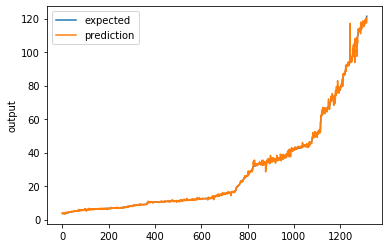

In [37]:
chart_regression(cnn_model_pred.flatten(),y_test_cnn)

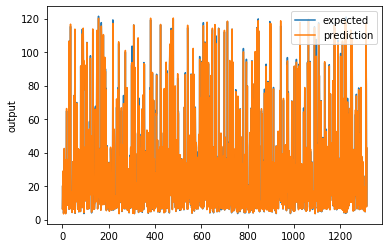

In [38]:
chart_regression(cnn_model_pred.flatten(),y_test_cnn,sort=False)

## Additional Feature

### Best value for number of days (N) we should consider in past for LSTM.

### N=2

In [24]:
#Preparing x and y
SEQUENCE_SIZE = 2
x,y = to_sequences(SEQUENCE_SIZE, df.values, df_stock_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4389, 2, 5)
Shape of y: (4389,)


In [25]:
x_train_lstm,x_test_lstm,y_train_lstm,y_test_lstm = train_test_split(x,y, test_size=0.3, random_state =42)
print("Shape of x_train: {}".format(x_train_lstm.shape))
print("Shape of x_test: {}".format(x_test_lstm.shape))
print("Shape of y_train: {}".format(y_train_lstm.shape))
print("Shape of y_test: {}".format(y_test_lstm.shape))

Shape of x_train: (3072, 2, 5)
Shape of x_test: (1317, 2, 5)
Shape of y_train: (3072,)
Shape of y_test: (1317,)


In [26]:
#checkpointer
checkpointer = ModelCheckpoint(filepath="best_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    print(i)    
    print('Build model...')
    model = Sequential()
    model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1,input_shape=(2, 5)))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 


0
Build model...
Train...
Train on 3072 samples, validate on 1317 samples
Epoch 1/1000
3072/3072 - 5s - loss: 1012.8226 - val_loss: 59.0606
Epoch 2/1000
3072/3072 - 1s - loss: 38.4706 - val_loss: 3.7481
Epoch 3/1000
3072/3072 - 2s - loss: 30.2159 - val_loss: 4.3651
Epoch 4/1000
3072/3072 - 1s - loss: 31.8436 - val_loss: 3.3918
Epoch 5/1000
3072/3072 - 1s - loss: 27.9114 - val_loss: 3.2938
Epoch 6/1000
3072/3072 - 1s - loss: 25.1406 - val_loss: 2.8055
Epoch 7/1000
3072/3072 - 1s - loss: 25.8277 - val_loss: 3.2884
Epoch 8/1000
3072/3072 - 1s - loss: 24.2095 - val_loss: 3.3893
Epoch 9/1000
3072/3072 - 1s - loss: 24.0399 - val_loss: 5.2356
Epoch 10/1000
3072/3072 - 1s - loss: 24.3575 - val_loss: 3.1328
Epoch 11/1000
3072/3072 - 1s - loss: 21.6374 - val_loss: 2.7312
Epoch 12/1000
3072/3072 - 1s - loss: 26.7630 - val_loss: 2.2476
Epoch 13/1000
3072/3072 - 1s - loss: 25.7708 - val_loss: 3.1476
Epoch 14/1000
3072/3072 - 1s - loss: 22.2392 - val_loss: 3.2586
Epoch 15/1000
3072/3072 - 1s - loss:

RMSE         : 1.3428704923662471
MSE          : 1.803301159267967
R2 score     : 0.9979426101200721


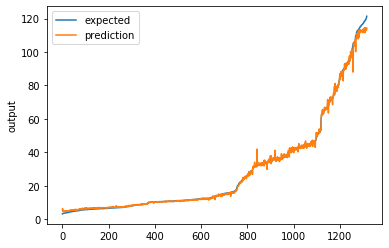

In [28]:
from sklearn import metrics
from sklearn.metrics import r2_score
model.load_weights('best_weights_lstm.hdf5')
pred = model.predict(x_test_lstm)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_lstm))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(y_test_lstm, pred))
print("R2 score     :",metrics.r2_score(y_test_lstm,pred))
# Plot the chart
chart_regression(pred.flatten(),y_test_lstm)

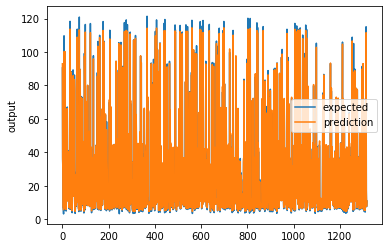

In [29]:
chart_regression(pred.flatten(),y_test_lstm,sort=False)

###  N=4

In [30]:
#Preparing x and y
SEQUENCE_SIZE = 4
x,y = to_sequences(SEQUENCE_SIZE, df.values, df_stock_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4387, 4, 5)
Shape of y: (4387,)


In [31]:
x_train_lstm,x_test_lstm,y_train_lstm,y_test_lstm = train_test_split(x,y, test_size=0.3, random_state =42)
print("Shape of x_train: {}".format(x_train_lstm.shape))
print("Shape of x_test: {}".format(x_test_lstm.shape))
print("Shape of y_train: {}".format(y_train_lstm.shape))
print("Shape of y_test: {}".format(y_test_lstm.shape))

Shape of x_train: (3070, 4, 5)
Shape of x_test: (1317, 4, 5)
Shape of y_train: (3070,)
Shape of y_test: (1317,)


In [32]:
#checkpointer
checkpointer = ModelCheckpoint(filepath="best_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    print(i)    
    print('Build model...')
    model = Sequential()
    model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1,input_shape=(4, 5)))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 


0
Build model...
Train...
Train on 3070 samples, validate on 1317 samples
Epoch 1/1000
3070/3070 - 8s - loss: 800.6661 - val_loss: 32.2884
Epoch 2/1000
3070/3070 - 2s - loss: 42.0115 - val_loss: 12.0259
Epoch 3/1000
3070/3070 - 3s - loss: 31.9269 - val_loss: 3.6905
Epoch 4/1000
3070/3070 - 2s - loss: 31.4663 - val_loss: 3.9213
Epoch 5/1000
3070/3070 - 2s - loss: 31.4742 - val_loss: 6.3967
Epoch 6/1000
3070/3070 - 3s - loss: 28.5280 - val_loss: 2.9016
Epoch 7/1000
3070/3070 - 2s - loss: 28.0868 - val_loss: 5.8554
Epoch 8/1000
3070/3070 - 2s - loss: 25.6137 - val_loss: 3.8209
Epoch 9/1000
3070/3070 - 2s - loss: 23.3233 - val_loss: 7.4333
Epoch 10/1000
3070/3070 - 2s - loss: 23.9259 - val_loss: 2.1033
Epoch 11/1000
3070/3070 - 2s - loss: 21.2045 - val_loss: 1.8787
Epoch 12/1000
3070/3070 - 2s - loss: 21.9005 - val_loss: 5.2207
Epoch 13/1000
3070/3070 - 3s - loss: 18.8819 - val_loss: 1.6728
Epoch 14/1000
3070/3070 - 2s - loss: 20.6898 - val_loss: 8.6305
Epoch 15/1000
3070/3070 - 2s - loss:

3070/3070 - 2s - loss: 16.6529 - val_loss: 1.7303
Epoch 24/1000
3070/3070 - 2s - loss: 17.2090 - val_loss: 5.6086
Epoch 00024: early stopping


RMSE         : 1.0294291980297656
MSE          : 1.0597244737562066
R2 score     : 0.9987681723204844


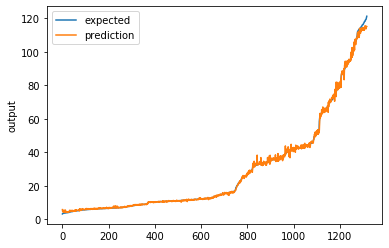

In [33]:
model.load_weights('best_weights_lstm.hdf5')
pred = model.predict(x_test_lstm)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_lstm))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(y_test_lstm, pred))
print("R2 score     :",metrics.r2_score(y_test_lstm,pred))
# Plot the chart
chart_regression(pred.flatten(),y_test_lstm)

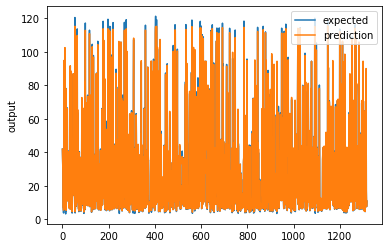

In [34]:
chart_regression(pred.flatten(),y_test_lstm,sort=False)

###  N=10

In [35]:
#Preparing x and y
SEQUENCE_SIZE = 10
x,y = to_sequences(SEQUENCE_SIZE, df.values, df_stock_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4381, 10, 5)
Shape of y: (4381,)


In [36]:
x_train_lstm,x_test_lstm,y_train_lstm,y_test_lstm = train_test_split(x,y, test_size=0.3, random_state =42)
print("Shape of x_train: {}".format(x_train_lstm.shape))
print("Shape of x_test: {}".format(x_test_lstm.shape))
print("Shape of y_train: {}".format(y_train_lstm.shape))
print("Shape of y_test: {}".format(y_test_lstm.shape))

Shape of x_train: (3066, 10, 5)
Shape of x_test: (1315, 10, 5)
Shape of y_train: (3066,)
Shape of y_test: (1315,)


In [37]:
#checkpointer
checkpointer = ModelCheckpoint(filepath="best_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    print(i)    
    print('Build model...')
    model = Sequential()
    model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1,input_shape=(10, 5)))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 


0
Build model...
Train...
Train on 3066 samples, validate on 1315 samples
Epoch 1/1000
3066/3066 - 14s - loss: 671.6882 - val_loss: 38.4827
Epoch 2/1000
3066/3066 - 5s - loss: 42.0940 - val_loss: 6.1378
Epoch 3/1000
3066/3066 - 4s - loss: 33.9655 - val_loss: 5.2140
Epoch 4/1000
3066/3066 - 4s - loss: 29.2663 - val_loss: 4.9048
Epoch 5/1000
3066/3066 - 4s - loss: 27.6781 - val_loss: 4.8277
Epoch 6/1000
3066/3066 - 4s - loss: 25.8736 - val_loss: 3.8007
Epoch 7/1000
3066/3066 - 4s - loss: 23.2640 - val_loss: 10.0326
Epoch 8/1000
3066/3066 - 5s - loss: 24.5945 - val_loss: 2.9155
Epoch 9/1000
3066/3066 - 6s - loss: 19.8078 - val_loss: 5.7916
Epoch 10/1000
3066/3066 - 4s - loss: 23.2285 - val_loss: 5.8037
Epoch 11/1000
3066/3066 - 4s - loss: 19.5444 - val_loss: 5.1724
Epoch 12/1000
3066/3066 - 4s - loss: 21.6810 - val_loss: 3.5580
Epoch 13/1000
3066/3066 - 4s - loss: 20.2012 - val_loss: 3.5816
Epoch 00013: early stopping
1
Build model...
Train...
Train on 3066 samples, validate on 1315 sampl

RMSE         : 1.4692524263396753
MSE          : 2.1587026923050234
R2 score     : 0.9975779985516923


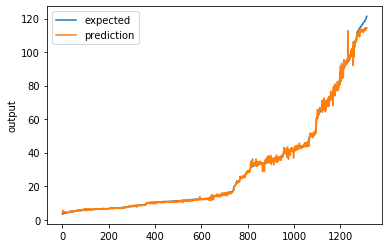

In [38]:
model.load_weights('best_weights_lstm.hdf5')
pred = model.predict(x_test_lstm)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_lstm))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(y_test_lstm, pred))
print("R2 score     :",metrics.r2_score(y_test_lstm,pred))
# Plot the chart
chart_regression(pred.flatten(),y_test_lstm)

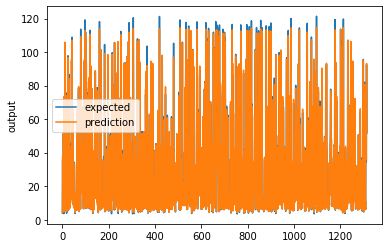

In [39]:
chart_regression(pred.flatten(),y_test_lstm,sort=False)

### N=20 

In [40]:
#Preparing x and y
SEQUENCE_SIZE = 20
x,y = to_sequences(SEQUENCE_SIZE, df.values, df_stock_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4371, 20, 5)
Shape of y: (4371,)


In [41]:
x_train_lstm,x_test_lstm,y_train_lstm,y_test_lstm = train_test_split(x,y, test_size=0.3, random_state =42)
print("Shape of x_train: {}".format(x_train_lstm.shape))
print("Shape of x_test: {}".format(x_test_lstm.shape))
print("Shape of y_train: {}".format(y_train_lstm.shape))
print("Shape of y_test: {}".format(y_test_lstm.shape))

Shape of x_train: (3059, 20, 5)
Shape of x_test: (1312, 20, 5)
Shape of y_train: (3059,)
Shape of y_test: (1312,)


In [42]:
#checkpointer
checkpointer = ModelCheckpoint(filepath="best_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    print(i)    
    print('Build model...')
    model = Sequential()
    model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1,input_shape=(20, 5)))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 


0
Build model...
Train...
Train on 3059 samples, validate on 1312 samples
Epoch 1/1000
3059/3059 - 19s - loss: 1022.3111 - val_loss: 762.1348
Epoch 2/1000
3059/3059 - 7s - loss: 266.9826 - val_loss: 18.6234
Epoch 3/1000
3059/3059 - 6s - loss: 47.6840 - val_loss: 15.0736
Epoch 4/1000
3059/3059 - 9s - loss: 35.7535 - val_loss: 12.9782
Epoch 5/1000
3059/3059 - 7s - loss: 26.8666 - val_loss: 7.3746
Epoch 6/1000
3059/3059 - 7s - loss: 27.5706 - val_loss: 11.6025
Epoch 7/1000
3059/3059 - 9s - loss: 21.5962 - val_loss: 6.6168
Epoch 8/1000
3059/3059 - 8s - loss: 22.5486 - val_loss: 5.7145
Epoch 9/1000
3059/3059 - 7s - loss: 20.6385 - val_loss: 6.6306
Epoch 10/1000
3059/3059 - 7s - loss: 18.7530 - val_loss: 7.7931
Epoch 11/1000
3059/3059 - 7s - loss: 18.3903 - val_loss: 7.4262
Epoch 12/1000
3059/3059 - 15s - loss: 19.7806 - val_loss: 5.5021
Epoch 13/1000
3059/3059 - 6s - loss: 15.5338 - val_loss: 7.5645
Epoch 14/1000
3059/3059 - 6s - loss: 17.6515 - val_loss: 8.1495
Epoch 15/1000
3059/3059 - 6s

RMSE         : 1.5399281907985167
MSE          : 2.3713788328159926
R2 score     : 0.997420668182308


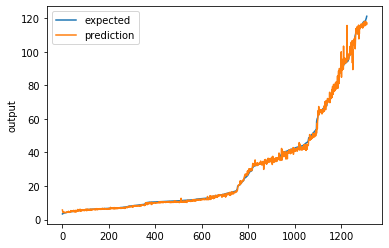

In [43]:
model.load_weights('best_weights_lstm.hdf5')
pred = model.predict(x_test_lstm)
score = np.sqrt(metrics.mean_squared_error(pred,y_test_lstm))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(y_test_lstm, pred))
print("R2 score     :",metrics.r2_score(y_test_lstm,pred))
# Plot the chart
chart_regression(pred.flatten(),y_test_lstm)

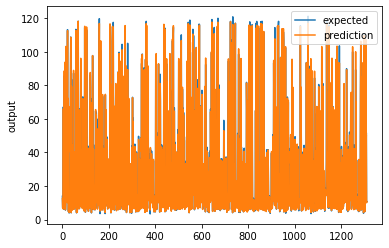

In [44]:
chart_regression(pred.flatten(),y_test_lstm,sort=False)